In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Data Preprocessing

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
import random as python_random

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# set seed
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# data preprocessing to float32
def get_preprocessed_data(images, labels):
    
    images = np.array(images/255.0, dtype=np.float32)

    
    return images, labels

# data preprocessing to one hot encoding
def get_preprocessed_ohe(images, labels):
    
    images, labels = get_preprocessed_data(images, labels)
    oh_labels = to_categorical(labels)
    
    return images, oh_labels

# train/validation/test split
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels)

In [3]:
# set random seed
set_random_seed(2021)

In [4]:
# CIFAR10 dataset load
(train_images, train_labels), (test_images, test_labels) = \
    cifar10.load_data()

print('train dataset shape: ', train_images.shape, train_labels.shape)
print('test dataset shape: ', test_images.shape, test_labels.shape)

170500096/170498071 [==============================] - 2s 0us/step
train dataset shape:  (50000, 32, 32, 3) (50000, 1)
test dataset shape:  (10000, 32, 32, 3) (10000, 1)


In [5]:
# CIFAR10 dataset preprocessing & split
(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)

print('train dataset shape: ', tr_images.shape, tr_oh_labels.shape)
print('validation dataset shape: ', val_images.shape, val_oh_labels.shape)
print('test dataset shape: ', test_images.shape, test_oh_labels.shape)

train dataset shape:  (42500, 32, 32, 3) (42500, 10)
validation dataset shape:  (7500, 32, 32, 3) (7500, 10)
test dataset shape:  (10000, 32, 32, 3) (10000, 10)


In [6]:
IMAGE_SIZE = 32

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()

### Model Create Function

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l1, l2, l1_l2

def create_model(verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00001))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    
    x = Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    
    x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same', kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(300, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.3)(x)
    
    output = Dense(10, activation='softmax', kernel_regularizer=l2(1e-5), name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)

    if verbose:
        model.summary()
    
    return model

In [19]:
model = create_model()

### Callbacks

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    mode='min',
    verbose=1
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=1
)

In [21]:
model.compile(
    optimizer=Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    x=tr_images,
    y=tr_oh_labels,
    batch_size=32,
    epochs=30,
    shuffle=True,
    validation_data=(val_images, val_oh_labels),
    callbacks=[rlr_cb, ely_cb]
)

Epoch 1/30
1329/1329 [==============================] - 22s 11ms/step - loss: 1.7466 - accuracy: 0.3954 - val_loss: 1.6856 - val_accuracy: 0.5100
Epoch 2/30
1329/1329 [==============================] - 13s 10ms/step - loss: 1.0766 - accuracy: 0.6408 - val_loss: 1.3300 - val_accuracy: 0.6008
Epoch 3/30
1329/1329 [==============================] - 13s 10ms/step - loss: 0.8724 - accuracy: 0.7228 - val_loss: 0.8446 - val_accuracy: 0.7408
Epoch 4/30
1329/1329 [==============================] - 13s 10ms/step - loss: 0.7583 - accuracy: 0.7694 - val_loss: 0.9030 - val_accuracy: 0.7337
Epoch 5/30
1329/1329 [==============================] - 13s 10ms/step - loss: 0.6758 - accuracy: 0.8095 - val_loss: 0.8369 - val_accuracy: 0.7549
Epoch 6/30
1329/1329 [==============================] - 13s 10ms/step - loss: 0.6150 - accuracy: 0.8358 - val_loss: 0.8433 - val_accuracy: 0.7705
Epoch 7/30
1329/1329 [==============================] - 13s 10ms/step - loss: 0.5685 - accuracy: 0.8573 - val_loss: 0.7802 -

In [23]:
model.evaluate(test_images, test_oh_labels)

313/313 [==============================] - 2s 5ms/step - loss: 1.0357 - accuracy: 0.8682


[1.035733938217163, 0.8682000041007996]

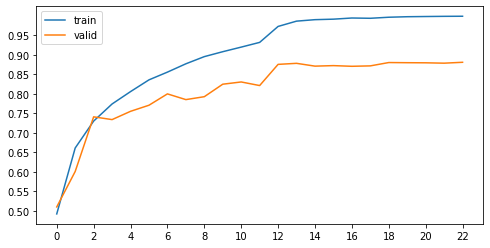

In [24]:
show_history(history)